# Investigate outlier state variables

Goal: Investigate why `state_Tr` and `state_Ts` show huge outliers in test scores

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '../../'))  # for importing local packages from src

### Loading data

In [2]:
RESULTS_CSV = 'test_results_nonan.csv'
# RESULTS_CSV = 'test_results.csv'

DATASET_NEMA_H0 = '../datasets/dataset_NEMA_NEMA_H0.csv'
DATASET_NEMA_H3 = '../datasets/dataset_NEMA_NEMA_H3.csv'
DATASET_NEMA_H15 = '../datasets/dataset_NEMA_NEMA_H15.csv'

Loading model fit results


In [12]:
data = pd.read_csv(RESULTS_CSV)

targets = data['target'].unique().tolist()
state_vars = data['state_var'].unique().tolist()
dataset_names = data['dataset'].unique().tolist()

data = data.set_index(['target', 'state_var', 'dataset'])

Loading datasets used in training

In [4]:
from src.model.rc_dataset import ExperimentDataset

dataset_nema_h0 = ExperimentDataset(csv_path=DATASET_NEMA_H0)
dataset_nema_h3 = ExperimentDataset(csv_path=DATASET_NEMA_H3)
dataset_nema_h15 = ExperimentDataset(csv_path=DATASET_NEMA_H15)

datasets = [
  ('NEMA_H0', dataset_nema_h0), 
  ('NEMA_H3', dataset_nema_h3), 
  ('NEMA_H15', dataset_nema_h15)
]

datasets_dict = {name : dataset for name, dataset in datasets}

### Exploring the worst performing target-state combinations

Note: to keep it simple we only look at the non-combined datasets

In [5]:
state_variables = ['state__Ts', 'state__Tr']
dataset_names = list(map(lambda x : x[0], datasets))

subdata = data.loc[:, state_variables, dataset_names]
top_worst = subdata.sort_values(by='test_score', ascending=True)
top_worst = top_worst.reset_index()

top_worst.head(10)

,target,state_var,dataset,Unnamed: 0,test_score,train_mean,train_std,cv_mean,cv_std
0,output__axes__C_exudated,state__Ts,NEMA_H15,206,-38.059350,-0.488004,0.037947,-0.710708,0.112067
1,output__axes__C_exudated,state__Ts,NEMA_H3,205,-24.348252,-0.418520,0.011048,-0.589969,0.018637
2,output__organ_roots__N_exudation,state__Ts,NEMA_H3,397,-23.689327,-0.320770,0.036175,-0.642209,0.161880
3,output__organ_roots__N_exudation,state__Ts,NEMA_H15,398,-19.062139,-0.589205,0.047325,-0.997626,0.236002
4,input_humidity,state__Ts,NEMA_H3,61,-18.729954,-0.162924,0.005502,-0.310868,0.085919
5,input_humidity,state__Ts,NEMA_H15,62,-11.886168,-0.162415,0.006232,-0.316894,0.016801
6,output__axes__Total_Transpiration,state__Ts,NEMA_H3,157,-11.323456,-0.113515,0.016212,-0.182597,0.063150
7,output__axes__C_exudated,state__Tr,NEMA_H15,218,-7.248791,-0.405925,0.049008,-0.728629,0.032357
8,input_air_temperature,state__Tr,NEMA_H15,26,-2.142242,-0.148414,0.011511,-0.247697,0.054213
9,output__axes__C_exudated,state__Tr,NEMA_H3,217,-2.060326,-0.375557,0.034551,-0.590348,0.129489


Let's plot the target against the state variable used in the model for the top worst test scores.

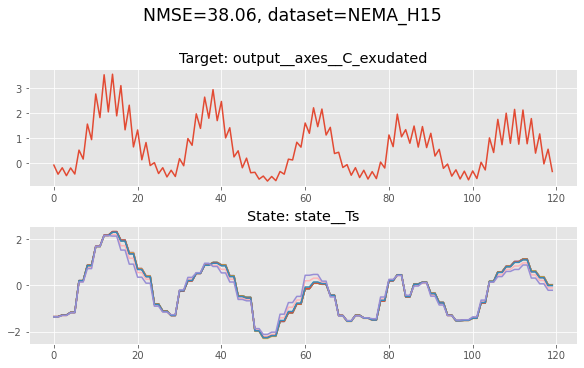

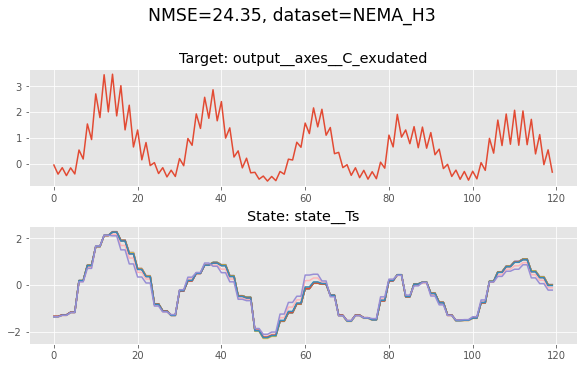

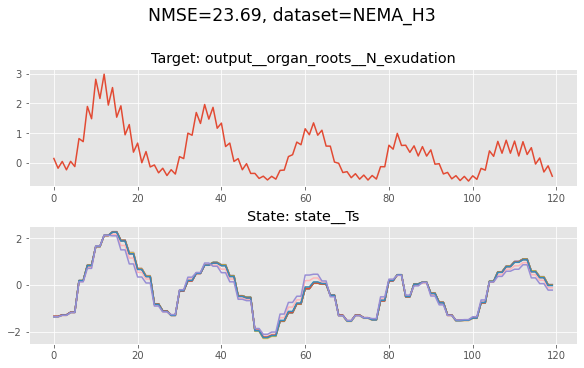

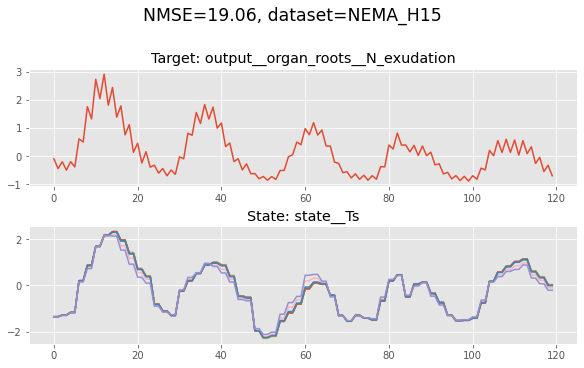

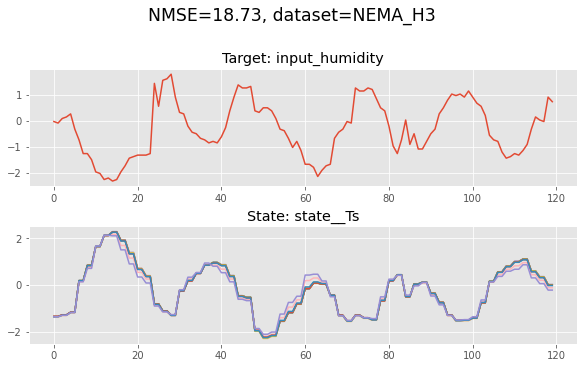

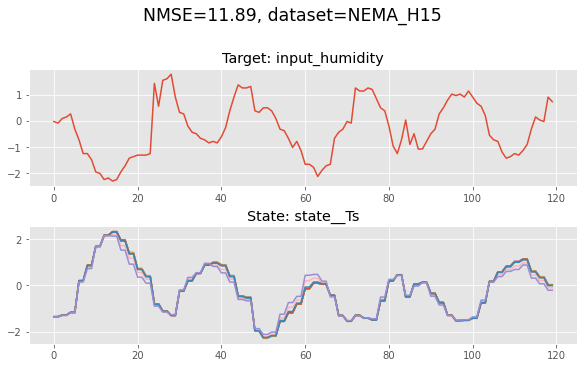

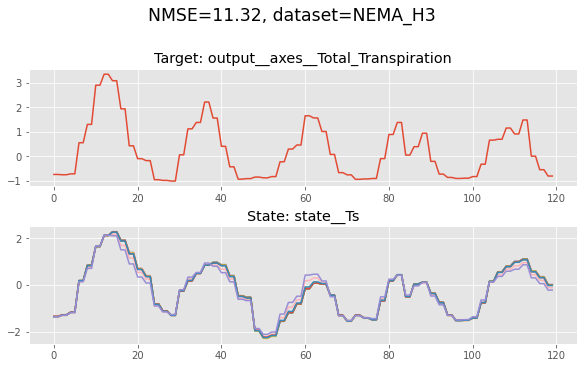

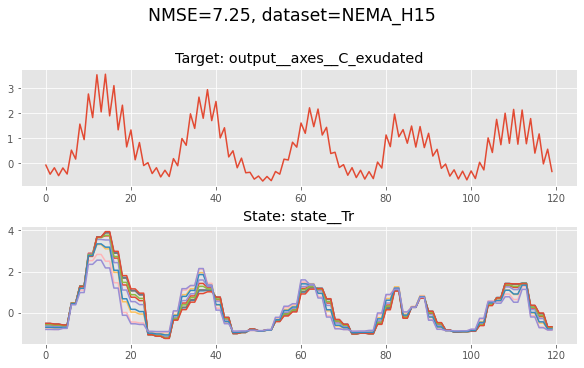

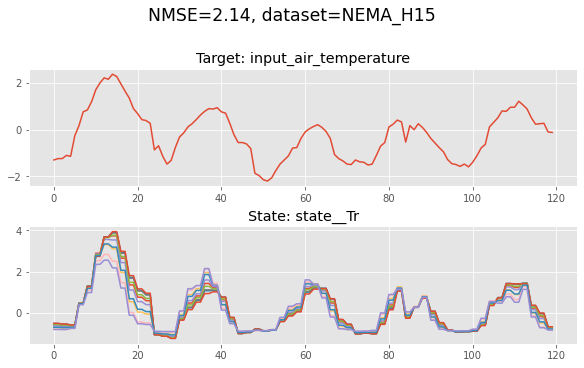

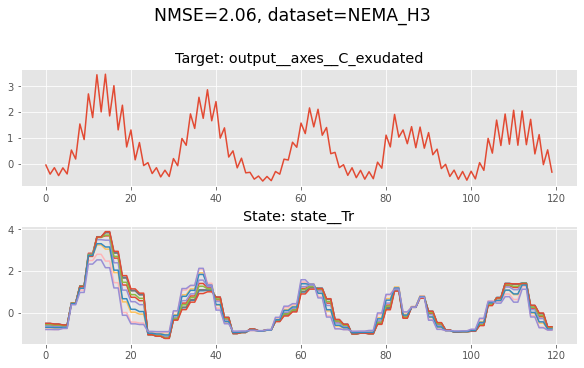

In [27]:
from model_config import max_time_step
from sklearn.preprocessing import StandardScaler


N_PLOTS = 10
T_MIN = 7 * 24
T_MAX = T_MIN + 5 * 24

def remove_null_nan(state):
  state_NaN = np.isnan(state)
  NaN_idx = np.any(state_NaN, axis=0)

  state_null = np.isclose(state, 0)
  null_idx = np.all(state_null, axis=0)

  state = state[:, ~NaN_idx & ~null_idx]
  return state


for i in range(N_PLOTS):

  target, state_var, dataset_name = top_worst.iloc[i].target, top_worst.iloc[i].state_var, top_worst.iloc[i].dataset
  dataset = datasets_dict[dataset_name]

  target_data = dataset.get_target(target, dataset_name)[:max_time_step[dataset_name]]
  var_data = dataset.get_state(state_var, dataset_name)[:max_time_step[dataset_name]]
  var_data = remove_null_nan(var_data)

  target_data = StandardScaler().fit_transform(target_data.to_numpy().reshape(-1, 1))
  var_data = StandardScaler().fit_transform(var_data)

  target_data = target_data[T_MIN:T_MAX]
  var_data = var_data[T_MIN:T_MAX]

  with plt.style.context('ggplot'):
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 5), constrained_layout=True)

    ax0.plot(target_data)
    ax0.set_title(f'Target: {target}')

    ax1.plot(var_data)
    ax1.set_title(f'State: {state_var}')

    fig.suptitle(f'NMSE={-top_worst.iloc[i].test_score:.2f}, dataset={dataset_name}\n', size='xx-large')

My hypothesis is that the gradual falloff in these targets makes them unsuited to be fitted by state__Ts (no correlation at all after the diminuation starts).

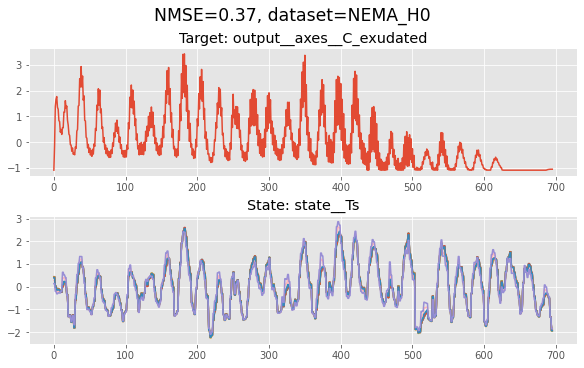

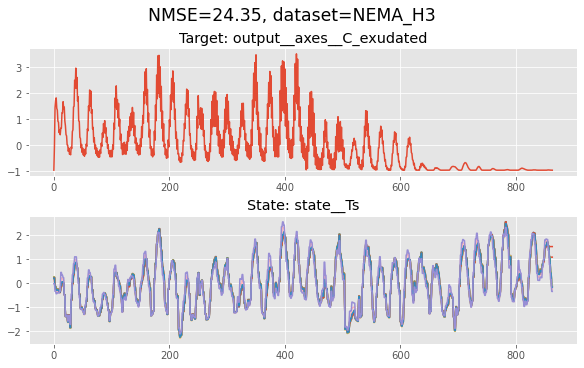

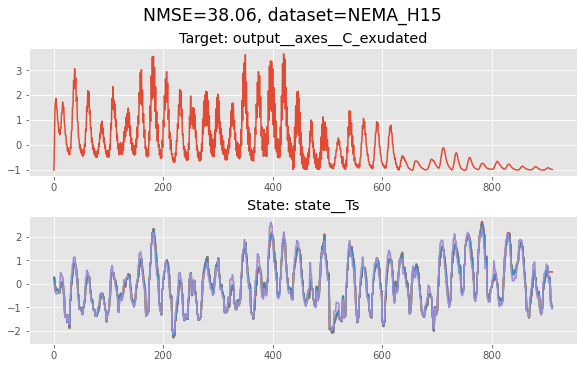

In [26]:
target = 'output__axes__C_exudated' 
state_var = 'state__Ts'

for dataset_name in ['NEMA_H0', 'NEMA_H3', 'NEMA_H15']:

  dataset = datasets_dict[dataset_name]

  target_data = dataset.get_target(target, dataset_name)[:max_time_step[dataset_name]]
  var_data = dataset.get_state(state_var, dataset_name)[:max_time_step[dataset_name]]
  var_data = remove_null_nan(var_data)

  target_data = StandardScaler().fit_transform(target_data.to_numpy().reshape(-1, 1))
  var_data = StandardScaler().fit_transform(var_data)

  with plt.style.context('ggplot'):
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(8, 5), constrained_layout=True)

    ax0.plot(target_data)
    ax0.set_title(f'Target: {target}')

    ax1.plot(var_data)
    ax1.set_title(f'State: {state_var}')

    fig.suptitle(f'NMSE={-data.loc[target, state_var, dataset_name]["test_score"]:.2f}, dataset={dataset_name}', size='xx-large')